<a href="https://colab.research.google.com/github/gavin-bauer/earth-vital-signs/blob/master/notebooks/arctic%20sea%20ice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARCTIC SEA ICE CONCENTRATION ANALYSIS

## **About**
Below is code part of a personal project called [Earth's Vital Signs](https://github.com/gavin-bauer/earth-vital-signs/blob/master/README.md) intended to develop my proficiency in Data Science Analytics tools and work on one of the most defining issues of our time. 

## **Findings**
![Arctic Sea Ice Extent](../assets/img/asie.png)

Between 1979 and 2015, the average monthly extent for September declined by 13% per decade, with a record low in 2012 when sea ice plummeted to 3.41mn square kilometers. 

Moreover, it appears that low minimum extents in the Arctic have become the “new normal” since the mid-2000s.

## **Datasets**
*NB: Note to reproduce the notebook, you need to create and download the dataset from the NSIDC website below.*
* [NASA/NSIDC](https://doi.org/10.5067/8GQ8LZQVL0VL)
* [NASA](https://climate.nasa.gov/system/internal_resources/details/original/1929_Arctic_data_1979-2019.txt)

### **Code**

In [0]:
# install cartopy in Google Colab
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# import libs
import os
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
import cartopy.crs as ccrs
import imageio as io
from PIL import Image

% matplotlib inline

In [0]:
def create_path(ROOT: str, file: str):
  path = os.path.join(ROOT, file)
  return path

def reshape_asic_data(path: str):
  with open(path, 'rb') as f:
    header = f.read(300)
    data = np.fromfile(f, dtype=np.uint8)
  data = data.reshape(448,304)
  data = data / 250.
  data = ma.masked_greater(data, 1.0)
  return data

def process_date(file: str):
  date = file[3:11]
  date = datetime(year=int(date[0:4]), month=int(date[4:6]), day=int(date[6:8]))
  date = date.strftime("%Y/%m/%d")
  return date

def plot_asic_data(ROOT: str, file: str, dx: int, dy: int, x: list, y: list):
  path = create_path(ROOT, file)
  data = reshape_asic_data(path)
  date = process_date(file)
  fig, ax = plt.subplots()
  ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
  cs = ax.coastlines(resolution='110m', linewidth=0.5)
  ax.gridlines()
  ax.set(title=f'Arctic Sea Ice Concentration in {date}')
  ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
  kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
  cs = ax.pcolormesh(x, y, data, cmap=plt.cm.Blues,
                    transform=ccrs.Stereographic(**kw))
  return date, ax

def make_gif():
  file_names = sorted((fn for fn in os.listdir('/content') if fn.endswith('png')))
  with io.get_writer('asic.gif', mode='I', duration=0.5) as writer:
    for filename in file_names:
      image = io.imread(filename)
      writer.append_data(image)
  writer.close()

def process_arctic_data(link: str):
  data = pd.read_csv(link, sep='\t')
  data.columns = ['year', 'month', 'data_type', 'region', 'extent', 'area']
  data = data[['year', 'extent']]
  return data

def plot_arctic_data(link: str):
  data = process_arctic_data(link)
  year = pd.to_numeric(data['year'])
  extent = pd.to_numeric(data['extent'])
  fig, ax = plt.subplots()
  ax.plot(year, extent)
  ax.set(xlabel='year', ylabel='area in million sq km',
        title='Arctic Sea Ice Extent Evolution')
  ax.set_yticks(np.arange(3,8,1))
  ax.grid(color='#7f7f7f', linewidth=0.2)
  return ax

In [0]:
ROOT = 'gdrive/My Drive/datasets/asic'
files = ['nt_19790901_n07_v1.1_n.bin', 'nt_19890901_f08_v1.1_n.bin',
         'nt_19990901_f13_v1.1_n.bin', 'nt_20090901_f17_v1.1_n.bin',
         'nt_20180901_f17_v1.1_n.bin']
dx = dy = 25000
x = np.arange(-3850000, +3750000, +dx)
y = np.arange(+5850000, -5350000, -dy)

In [0]:
for file in files:
  date, ax = plot_asic_data(ROOT, file, dx, dy, x, y)
  year = date[:4]
  PATH = os.path.join('/content', f'asic_{year}')
  chart = ax.get_figure()
  chart.savefig(PATH, dpi=150)
  
make_gif()

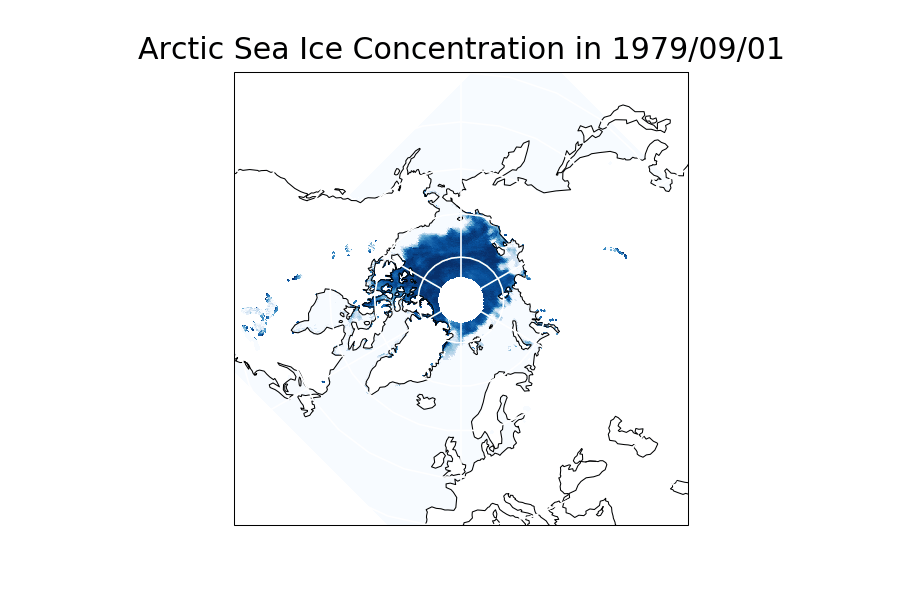

In [0]:
Image.open('asic.gif')

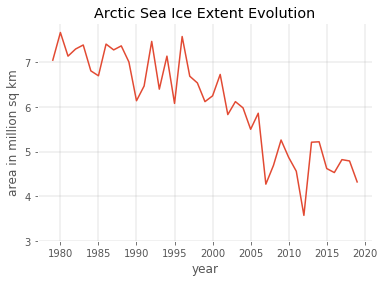

In [0]:
link = 'https://climate.nasa.gov/system/internal_resources/details/original/1929_Arctic_data_1979-2019.txt'
PATH = os.path.join('/content', f'asic_arctic_extent')
ax = plot_arctic_data(link)
chart = ax.get_figure()
chart.savefig(PATH, dpi=150)